In [1]:
import sys
#sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom_fork') # ut.py etc. (github)
sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master') # 

import matplotlib
#matplotlib.use('Agg') #-- use in batch mode
matplotlib.use('TkAgg')
from netCDF4 import Dataset, MFDataset
import pyfesom as pf
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import cm
from colorbars import cmap_correlations256
import seawater as sw

In [2]:
%matplotlib inline
%load_ext ipycache

/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


#### first, define some functions for loading and plotting of the data (re-used for all the grids!)

In [3]:
def load_andcompute_TSRho(firstyear, lastyear, mesh, filetmp ):
    "Load and compute mean T, S, and density (sigma1) for the period (firstyear---lastyear)."
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    print 'Computing mean ...'
    temp = fl.variables['temp'][:,:].mean(axis=0) # 1x 3D field
    salt = fl.variables['salt'][:,:].mean(axis=0) # 1x 3D field
    print 'Done.'

    # load climatology
    climpath='/mnt/lustre01/work/bm0944/a270046/DATA/climatology/'
    clim = pf.climatology(climpath, climname='phc') # climname='phc'|'woa05'
    
    # map fesom data to PHC climatology grid
    xx,yy,zz_temp_pot = pf.fesom2clim(temp, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=200000)
    xx,yy,zz_salt = pf.fesom2clim(salt, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=200000)

    # initialize additional variables
    zz_temp_insitu=np.copy(zz_temp_pot)

    zz_sigma_1=np.zeros_like(zz_temp_pot)
    PHC_temp_insitu=np.zeros_like(zz_temp_pot)
    PHC_sigma_1=np.zeros_like(zz_temp_pot)

    # for every layer (0 ... 32):
    for ilevel in np.arange(np.shape(clim.z)[0]):
    
       # FESOM PART
       # calculates temperature from potential temperature at the reference pressure PR and in situ pressure P
       zz_temp_insitu[ilevel,:,:]=sw.eos80.temp(zz_salt[ilevel,:,:], zz_temp_pot[ilevel,:,:], clim.z[ilevel], pr=0)
    
       # density of Sea Water using UNESCO 1983 (EOS 80) polynomial
       zz_sigma_1[ilevel,:,:]=sw.eos80.pden(zz_salt[ilevel,:,:], zz_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
       # PHC PART (pot. 'clim' values are loaded in newest version of pyfesom)
       PHC_temp_insitu[ilevel,:,:]=sw.eos80.temp(clim.S[ilevel,:,:], clim.T[ilevel,:,:], clim.z[ilevel], pr=0)
       PHC_sigma_1[ilevel,:,:]=sw.eos80.pden(clim.S[ilevel,:,:], PHC_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
    return xx,yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1

In [4]:
def load_andcompute_TSRho_split(firstyear, lastyear, mesh, filetmp):
    "Load and compute mean T, S, and density (sigma1) for the period (firstyear---lastyear). Split the computation in parts if you encounter memory errors."
    
    ## load the files into one dataset
    #files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    #fl = MFDataset(files)
    #
    #print 'Computing mean ...'
    #temp = fl.variables['temp'][:,:].mean(axis=0) # 1x 3D field
    #salt = fl.variables['salt'][:,:].mean(axis=0) # 1x 3D field
    #print 'Done.'
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    # initialize
    dim3D=np.shape(fl.variables['temp'][0,:])[0]
    temp=np.zeros(dim3D)
    salt=np.zeros(dim3D)

    print 'Computing mean ...'
    temp[0:dim3D/2] = fl.variables['temp'][:,0:dim3D/2].mean(axis=0) # 1x 3D field
    temp[dim3D/2:] = fl.variables['temp'][:,dim3D/2:].mean(axis=0) # 1x 3D field
    salt[0:dim3D/2] = fl.variables['salt'][:,0:dim3D/2].mean(axis=0) # 1x 3D field
    salt[dim3D/2:] = fl.variables['salt'][:,dim3D/2:].mean(axis=0) # 1x 3D field
    print 'Done.'

    # load climatology
    climpath='/mnt/lustre01/work/bm0944/a270046/DATA/climatology/'
    clim = pf.climatology(climpath, climname='phc') # climname='phc'|'woa05'
    
    # map fesom data to PHC climatology grid
    xx,yy,zz_temp_pot = pf.fesom2clim(temp, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=200000)
    xx,yy,zz_salt = pf.fesom2clim(salt, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=200000)

    # initialize additional variables
    zz_temp_insitu=np.copy(zz_temp_pot)

    zz_sigma_1=np.zeros_like(zz_temp_pot)
    PHC_temp_insitu=np.zeros_like(zz_temp_pot)
    PHC_sigma_1=np.zeros_like(zz_temp_pot)

    # for every layer (0 ... 32):
    for ilevel in np.arange(np.shape(clim.z)[0]):
    
       # FESOM PART
       # calculates temperature from potential temperature at the reference pressure PR and in situ pressure P
       zz_temp_insitu[ilevel,:,:]=sw.eos80.temp(zz_salt[ilevel,:,:], zz_temp_pot[ilevel,:,:], clim.z[ilevel], pr=0)
    
       # density of Sea Water using UNESCO 1983 (EOS 80) polynomial
       zz_sigma_1[ilevel,:,:]=sw.eos80.pden(zz_salt[ilevel,:,:], zz_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
       # PHC PART (pot. 'clim' values are loaded in newest version of pyfesom)
       PHC_temp_insitu[ilevel,:,:]=sw.eos80.temp(clim.S[ilevel,:,:], clim.T[ilevel,:,:], clim.z[ilevel], pr=0)
       PHC_sigma_1[ilevel,:,:]=sw.eos80.pden(clim.S[ilevel,:,:], PHC_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
    return xx,yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1

In [5]:
def load_andremap_MLD(firstyear, lastyear, mesh, filetmp):
    "Load and compute (mean) mixed layer depth for the period (firstyear---lastyear)."
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    print 'Computing mean, max, min ...'
    MLDmean = fl.variables['mixlay'][:,:].mean(axis=0) # 1x 2D field
    MLDmax = fl.variables['mixlay'][:,:].max(axis=0) # 1x 2D field
    MLDmin = fl.variables['mixlay'][:,:].min(axis=0) # 1x 2D field
    print 'Done.'

    # load climatology
    climpath='/mnt/lustre01/work/bm0944/a270046/DATA/climatology/'
    clim = pf.climatology(climpath, climname='phc') # climname='phc'|'woa05'
    
    # map fesom data to PHC climatology grid
    xx,yy = np.meshgrid(clim.x, clim.y)
    zz_MLDmean=np.zeros((clim.T.shape[1], clim.T.shape[2]))
    zz_MLDmax =np.zeros((clim.T.shape[1], clim.T.shape[2]))
    zz_MLDmin =np.zeros((clim.T.shape[1], clim.T.shape[2]))
    
    distances, inds = pf.create_indexes_and_distances(mesh, xx, yy, k=10, n_jobs=2)
    
    # remap mean
    zz_MLDmean[:,:] = pf.fesom2regular(MLDmean, mesh, xx, yy, distances=distances,\
                                inds=inds, how='idist', k=10,\
                                radius_of_influence=200000)
    zz_MLDmax[:,:]  = pf.fesom2regular(MLDmax , mesh, xx, yy, distances=distances,\
                                inds=inds, how='idist', k=10,\
                                radius_of_influence=200000)
    zz_MLDmin[:,:]  = pf.fesom2regular(MLDmin , mesh, xx, yy, distances=distances,\
                                inds=inds, how='idist', k=10,\
                                radius_of_influence=200000)
    
    # set land to NaN
    zz_MLDmean[np.isnan(clim.T[0,:,:])]=np.nan
    zz_MLDmax[np.isnan(clim.T[0,:,:])]=np.nan
    zz_MLDmin[np.isnan(clim.T[0,:,:])]=np.nan
    
    return xx,yy, zz_MLDmean, zz_MLDmax, zz_MLDmin

## Now loop everything, with moving window

In [16]:
#ls /pf/a/a270046/hierarchy/new_figures/paper-animation/

### CORE, find isopycnal layers of interest

In [7]:
#mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/LR/gibraltar

In [8]:
#mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/REF/gibraltar

In [9]:
#mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/MR0/gibraltar

In [10]:
#mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/MR/gibraltar

In [11]:
#mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/HR/gibraltar

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/joblib_mesh
2048 2049 2
Computing mean ...
Done.
Computing mean, max, min ...
Done.


/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less_equal


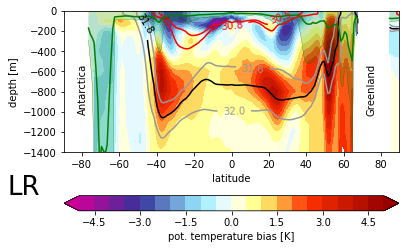

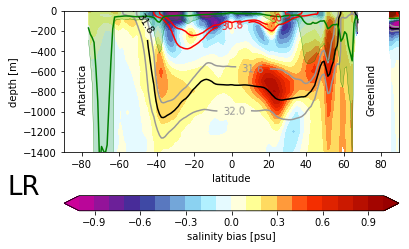

In [13]:
# config
meshname4plots ='LR'
meshpath  ='/work/bm0944/input/CORE2_final/' # COREII at DKRZ
savepath ='/pf/a/a270046/hierarchy/new_figures/paper-animation/meridional_ATL/LR/'

#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.mean.nc' # COREII data at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.diag.nc' # COREII data at DKRZ
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # annual COREII data at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

# animate the development with running window
#window=10 # e.g. 10 years
#for firstyear in np.arange(2008,2107-(window-2)):
# test the loop with shorter window:
window=2
for firstyear in np.arange(2048,2049): #41-50
    
    lastyear=firstyear+(window-1) # e.g. 10yr period
    print firstyear, lastyear, lastyear-firstyear+1

    # load data and compute density for above period
    xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
    xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filedia)
    # create new figure
    fig=plt.figure(figsize=(6,4))

    ## compute the biases and cut out section(s)
    
    # T & S bias, 3D
    bias=zz_temp_pot-clim.T
    bias_S=zz_salt-clim.S

    # --- SECTION 1
    # T & S bias along section 1
    sect_lon=-30.5
    sect_layer=np.zeros((33,180)) # -30.5
    sect_layer_S=np.zeros((33,180)) # -30.5

    # sigma layers in model and PHC, section 1
    sigm_layer=np.zeros((33,180)) # -30.5
    sigm_layer_PHC=np.zeros((33,180)) # -30.5

    # mixed layer along section 1
    mld_sim=np.zeros((1,180))
    # --- SECTION 1

    # for every layer (0 ... 32):
    for ilevel in np.arange(np.shape(clim.z)[0]):
        layer=bias[ilevel,:,:]
        layer_S=bias_S[ilevel,:,:]
        layersigma=zz_sigma_1[ilevel,:,:]
        layersigma_PHC=PHC_sigma_1[ilevel,:,:]
    
        # --- SECTION 1
        # T & S bias along section
        sect_layer[ilevel,:]=layer[xx==sect_lon]
        sect_layer_S[ilevel,:]=layer_S[xx==sect_lon]
        # sigma layers, section
        sigm_layer[ilevel,:]=layersigma[xx==sect_lon]
        sigm_layer_PHC[ilevel,:]=layersigma_PHC[xx==sect_lon]

        # now mixed layer
        mld_mean= zz_MLDmean[xx==sect_lon]
        mld_max = zz_MLDmax[xx==sect_lon]
        # --- SECTION 1
        
    ####
           

    # plot the T section
    levels = np.arange(-5, 5.+0.5, 0.5) # -5 to 5 degrees
    YY,CLIMZ=np.meshgrid(yy[:,0], -clim.z[0:23])
    CS = plt.contourf(YY, CLIMZ, sect_layer[0:23,:], levels = levels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    cbar=plt.colorbar(CS, orientation = 'horizontal', pad=0.2, label='pot. temperature bias [K]')
    CS2 = plt.contour(YY, CLIMZ, sigm_layer[0:23,:], levels=np.round(np.array([30.5, 30.8, 31.6, 31.8, 32.0]),1),colors=['r','r','0.6','k','0.6']) # np.array([30.5, 30.8, 31.4, 31.6, 31.8, 32.0, 32.1])highlight some lines
    #manual_locations = [(-25, -100), (-20, -400), (0, -600), (0, -800), (-20,-1000)]
    #plt.clabel(CS2, inline=1, fontsize=10, manual=manual_locations, fmt='%1.1f')
    plt.clabel(CS2, inline=1, fontsize=10, fmt='%1.1f')
    
    # add mixed layer mean + max
    y2=-mld_max[:]
    y1=0.
    plt.fill_between(YY[0,:], y1, y2, where=y2 <= y1, facecolor='green', interpolate=True, alpha=0.2)
    plt.plot(YY[0,:], -mld_mean[:], color='g')
    plt.plot(YY[0,:], -mld_max[:], color='g', linewidth=0.3)
    
    plt.text(72,-600,'Greenland', rotation='90')
    plt.text(-82,-600,'Antarctica', rotation='90')
    plt.ylabel('depth [m]'), plt.xlabel('latitude')
    plt.annotate(meshname4plots, xy=(-0.17, -0.3), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=26)
    
    plt.ylim((-1400,0))
    
    saveFIG=False
    if saveFIG==True:
       pp = PdfPages(savepath+'paper_tempbias_'+meshname4plots+'minphc_section_'+str(firstyear)+'-'+str(lastyear)+'.pdf')
       pp.savefig(fig,bbox_inches = 'tight')
       pp.close()
    
    
    # create new figure
    fig2=plt.figure(figsize=(6,4))
    # plot the S section
    levels = np.arange(-1, 1.+0.1, 0.1) # -1 to 1 psu
    YY,CLIMZ=np.meshgrid(yy[:,0], -clim.z[0:23])
    CS = plt.contourf(YY, CLIMZ, sect_layer_S[0:23,:], levels = levels, cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    cbar=plt.colorbar(CS, orientation = 'horizontal', pad=0.2, label='salinity bias [psu]')
    CS2 = plt.contour(YY, CLIMZ, sigm_layer[0:23,:], levels=np.round(np.array([30.5, 30.8, 31.6, 31.8, 32.0]),1),colors=['r','r','0.6','k','0.6']) # np.array([30.5, 30.8, 31.4, 31.6, 31.8, 32.0, 32.1])highlight some lines
    plt.clabel(CS2, inline=1, fontsize=10, fmt='%1.1f')
    
    # add mixed layer mean + max
    y2=-mld_max[:]
    y1=0.
    plt.fill_between(YY[0,:], y1, y2, where=y2 <= y1, facecolor='green', interpolate=True, alpha=0.2)
    plt.plot(YY[0,:], -mld_mean[:], color='g')
    plt.plot(YY[0,:], -mld_max[:], color='g', linewidth=0.3)
    
    plt.text(72,-600,'Greenland', rotation='90')
    plt.text(-82,-600,'Antarctica', rotation='90')
    plt.ylabel('depth [m]'), plt.xlabel('latitude')
    plt.annotate(meshname4plots, xy=(-0.17, -0.3), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=26)
    
    plt.ylim((-1400,0))
    
    saveFIG=False
    if saveFIG==True:
       pp = PdfPages(savepath+'paper_saltbias_'+meshname4plots+'minphc_section_'+str(firstyear)+'-'+str(lastyear)+'.pdf')
       pp.savefig(fig2,bbox_inches = 'tight')
       pp.close()
    
    
    #plt.close("all") 

## Now animate it, 31.8 (and 32.0?) contours

In [14]:
#!mkdir -p /pf/a/a270046/hierarchy/new_figures/paper-animation-isosurface/LR/31_8/

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/joblib_mesh
2105 2106 2
Computing mean ...
Done.
Computing mean, max, min ...
Done.


/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


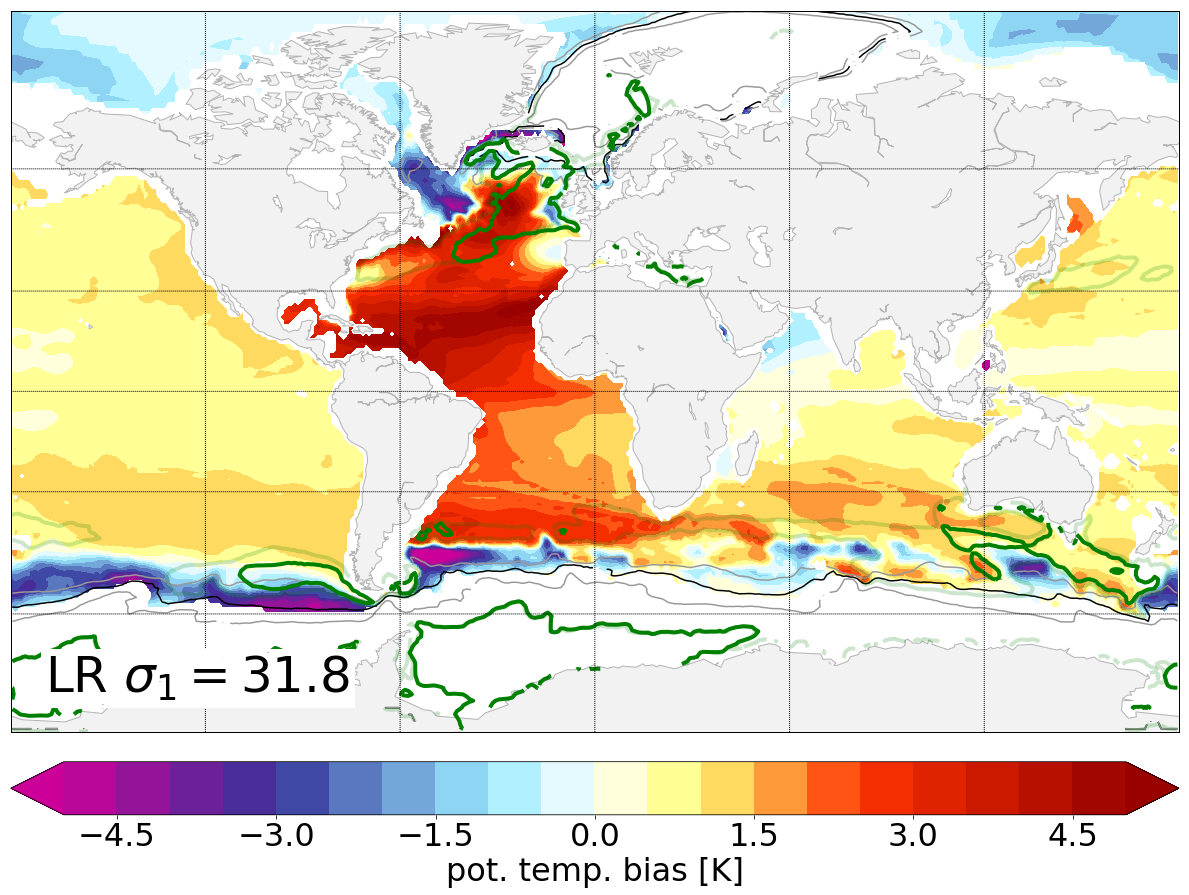

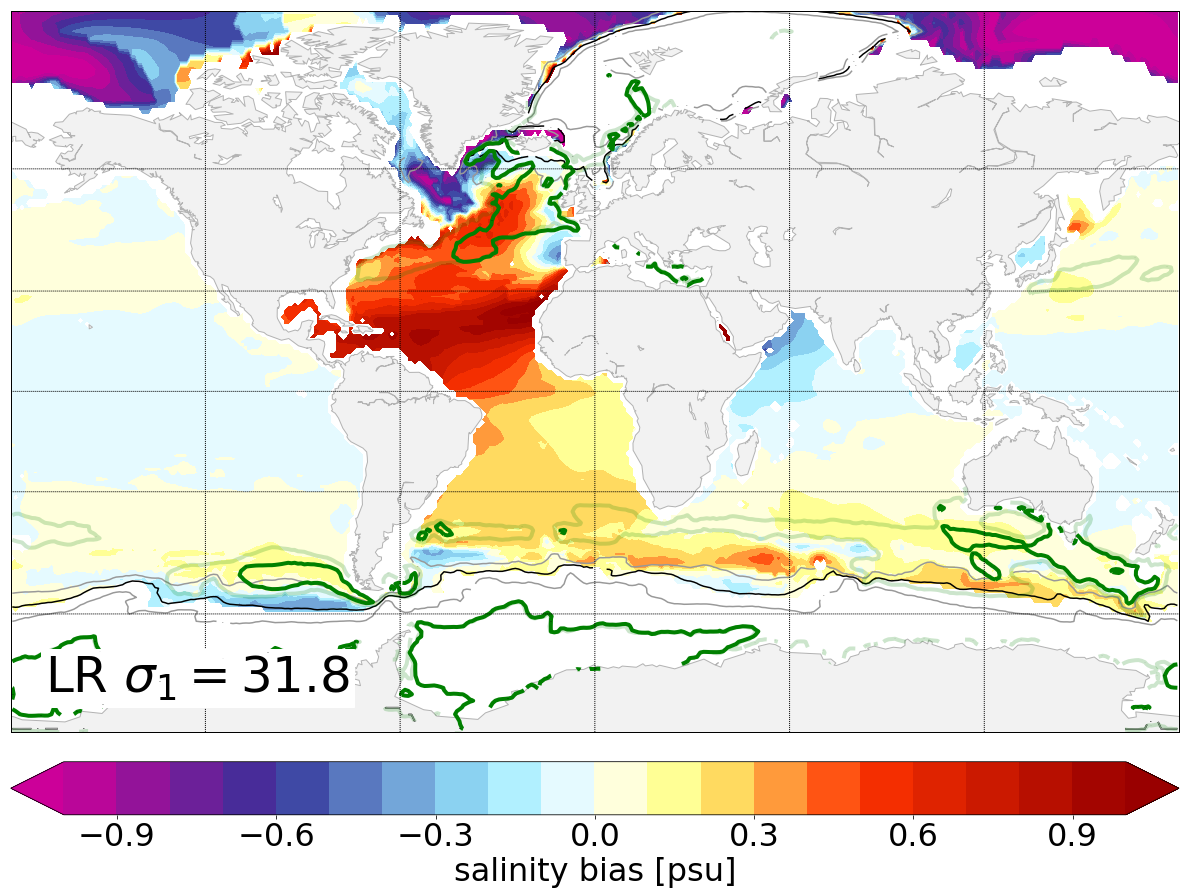

In [15]:
# config
meshname4plots ='LR'
meshpath = '/work/bm0944/input/CORE2_final/' # COREII at DKRZ
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.mean.nc' # COREII data at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.diag.nc' # COREII data at DKRZ
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # annual COREII data at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

# animate the development with running window
#window=10 # e.g. 10 years
#for firstyear in np.arange(2008,2107-(window-2)):
# test loop
window=2 # e.g. 10 years
for firstyear in np.arange(2105,2106):
    
    #firstyear=2008
    lastyear=firstyear+(window-1) # e.g. 10yr period
    print firstyear, lastyear, lastyear-firstyear+1

    # load data and compute density for above period
    xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
    xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
                                                                lastyear=lastyear, \
                                                                mesh=mesh, \
                                                                filetmp=filedia)
    # mask the sigma_1 NaNs
    zz_sigma_1_m=np.ma.masked_where(np.isnan(zz_sigma_1), zz_sigma_1)
    
    # ------------------------------------------------------- #
    # target contour
    target=31.8 #31.8
    contour_idx=np.zeros((33,180,360),dtype=np.int8) # the index matrix

    # for every ocean column:
    for idx_x in np.arange(0,180,1):
        for idx_y in np.arange(0,360,1):
        
            # all values in the column too far away from 31.8?
            #if np.all(np.abs(zz_sigma_1_m[:,idx_x,idx_y] - target)>0.3):
            #if np.all(np.abs(zz_sigma_1_m[:,idx_x,idx_y] - target)>0.2):  
            #if np.all(np.abs(zz_sigma_1_m[:,idx_x,idx_y] - target)>0.05):
            
            # the isopycnal layer already outcropped, only larger values in this area
            if np.all(zz_sigma_1_m[:,idx_x,idx_y] > target+0.05):   
                continue
            # the isopycnal layer hit the bathymetry, no outcropping, only lower values
            elif np.all(zz_sigma_1_m[:,idx_x,idx_y] < target-0.05):       
                continue
            # take the closest value (change this to interpolation in the future?)    
            else:    
                val = np.argmin(np.abs(zz_sigma_1_m[:,idx_x,idx_y] - target))    
                contour_idx[val,idx_x,idx_y] = 1 # val # use this depth
                #if val-1 != -1 and val+1 != 32:
                #    contour_idx[(val-1):(val+1)+1,idx_x,idx_y] = 1
                
                
    # T bias field; mask its NaNs            
    field=zz_temp_pot-clim.T
    field_m=np.ma.masked_where(np.isnan(field), field)     
    
    # mask most values, the ones that are NOT on the contour
    field_tmp = np.ma.masked_where(contour_idx==0,field_m)
    
    # reduce the field to a map (nansum because there is only one (up to 3?) value per ocean column)
    #field_mycontour=np.nansum(field_tmp, axis=0)
    field_mycontour=np.nanmean(field_tmp, axis=0)
    
    # T bias field; mask its NaNs            
    field_S=zz_salt-clim.S
    field_S_m=np.ma.masked_where(np.isnan(field_S), field_S)     
    
    # mask most values, the ones that are NOT on the contour
    field_S_tmp = np.ma.masked_where(contour_idx==0,field_S_m)
    
    # reduce the field to a map (nansum because there is only one (up to 3?) value per ocean column)
    #field_mycontour=np.nansum(field_tmp, axis=0)
    field_S_mycontour=np.nanmean(field_S_tmp, axis=0)
    
    # ------------------------------------------------------- #
    # plot FESOM T bias wrt PHC
    m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid

    annotation=meshname4plots
    fig=plt.figure(figsize=(33,14))

    plt.subplot(122)
    m.drawmapboundary(fill_color='white')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.7', antialiased=1)
    m.fillcontinents(color='0.95')

    levels = np.arange(-5., 5.5, 0.5)
    BIAS=plt.contourf(x, y, field_mycontour, levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    plt.annotate(meshname4plots+' $ \sigma_1=$'+str(target), xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=50)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    cbar.set_label('pot. temp. bias [K]', fontsize=32)
    cbar.ax.tick_params(labelsize=32)
    
    CS2 = plt.contour(x, y, zz_sigma_1[0,:,:], levels=np.arange(31.6,32.0+0.1,0.2),colors=['0.6','k','0.6'])
    plt.clabel(CS2, fmt='%2.1f', colors='k', fontsize=0)
    # add contour line for easier understanding
    
    # add MLD mean
    levels = [100.] #np.arange(200., 200.+100., 100.)
    MLD0=plt.contour(x, y, zz_MLDmean, levels = levels, \
                colors=['g'],linewidths=4, alpha=0.2) #alpha=0.2
    plt.clabel(MLD0, fmt='%2.1f', inline=False, colors='k', fontsize=0)
    # add max MLD
    levels = [500.] #np.arange(200., 200.+100., 100.)
    MLD1=plt.contour(x, y, zz_MLDmax, levels = levels, \
                colors=['g'],linewidths=4) #alpha=0.2
    plt.clabel(MLD1, fmt='%2.1f', inline=False, colors='k', fontsize=0)
    
    
    plt.tight_layout()
    #plt.show()
    
    saveFIG=False
    if saveFIG==True:
       pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/paper-animation-isosurface/LR/31_8/paper_tempbias_'+meshname4plots+'minphc_isosurface_'+str(target)+'_'+str(firstyear)+'-'+str(lastyear)+'.pdf')
       pp.savefig(fig,bbox_inches = 'tight')
       pp.close()
    
    # ------------------------------------------------------- #
    # also plot FESOM S bias wrt PHC
    fig2=plt.figure(figsize=(33,14))

    plt.subplot(122)
    m.drawmapboundary(fill_color='white')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.7', antialiased=1)
    m.fillcontinents(color='0.95')

    levels = np.arange(-1., 1.1, 0.1)
    BIAS=plt.contourf(x, y, field_S_mycontour, levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    plt.annotate(meshname4plots+' $ \sigma_1=$'+str(target), xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=50)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    cbar.set_label('salinity bias [psu]', fontsize=32)
    cbar.ax.tick_params(labelsize=32)
    
    CS2 = plt.contour(x, y, zz_sigma_1[0,:,:], levels=np.arange(31.6,32.0+0.1,0.2),colors=['0.6','k','0.6'])
    plt.clabel(CS2, fmt='%2.1f', colors='k', fontsize=0)
    # add contour line for easier understanding
    
    # add MLD mean
    levels = [100.] #np.arange(200., 200.+100., 100.)
    MLD0=plt.contour(x, y, zz_MLDmean, levels = levels, \
                colors=['g'],linewidths=4, alpha=0.2) #alpha=0.2
    plt.clabel(MLD0, fmt='%2.1f', inline=False, colors='k', fontsize=0)
    # add max MLD
    levels = [500.] #np.arange(200., 200.+100., 100.)
    MLD1=plt.contour(x, y, zz_MLDmax, levels = levels, \
                colors=['g'],linewidths=4) #alpha=0.2
    plt.clabel(MLD1, fmt='%2.1f', inline=False, colors='k', fontsize=0)
    
    
    plt.tight_layout()
    #plt.show()
    
    saveFIG=False
    if saveFIG==True:
       pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/paper-animation-isosurface/LR/31_8/paper_saltbias_'+meshname4plots+'minphc_isosurface_'+str(target)+'_'+str(firstyear)+'-'+str(lastyear)+'.pdf')
       pp.savefig(fig2,bbox_inches = 'tight')
       pp.close()
    
    #plt.close("all")                                        